In [1]:

import pandas as pd
import numpy as np
import time
import seaborn as sb
import datetime as dt
import matplotlib.pyplot as plt


In [2]:
t = '5/1/2020 16:15'
def format_date(t):
    if len(t)<11:
        t = t+' 12:00' #somehow the data is missing the 12pm timem stamp
    date,time = t.split(' ')
    month,day,year = date.split('/')
    hr,sec = time.split(':')

    return dt.datetime(int(year),int(month),int(day),int(hr),int(sec))
        

15


In [159]:
def test_strat(data,closing_hour,closing_minute,opening_hour,opening_minute):
    time_in_min = opening_hour *60 +opening_minute
    print(time_in_min)
    win = 0 
    lose = 0
    win_list = []
    lose_list = []
    current_day = None
    minute_counter = 0 
    price_weight = 0
    volume  = 0 
    close_price = -1
    VMAP = 0 
    side = -1 #1 indicates buy and 0 indicates sell
    entry_price =0 
    entry_volume = 0 
    counter  = 0 
    average_volume = 0
    for index, row in data.iterrows():
        date = format_date(row['Date'])
        if date.hour>15:
            continue

        if date.hour<9: 
            continue

        if date.hour == 9 and date.minute<30:
            continue

        if current_day == None or date.day != current_day: # new data reset everyhing
            #new_day
            current_day = date.day
            minute_counter  = 0
            price_weight = 0
            volume = 0
            entry_volume = 0
            if close_price == 0:
                print("missing closing for the day before" +str(date))
            close_price = 0
            VMAP = 0
            entry_price =0
            side = -1
            counter  = 0 
            average_volume = 0
        counter+=1
        volume+=row['Volume']
        price_weight+=row['Volume']*(row['High']+row['Low']+row['Close'])/3
        
        VMAP = price_weight/volume
        if (date.hour*60 + date.minute) >=time_in_min:
            if row['Open']>VMAP and entry_price == 0:
                side =1
            elif row['Open']<=VMAP and entry_price == 0:
                side =0 
        else:
            assert(side ==-1)
                
        if side != -1:
            if side and entry_price  == 0 :#buy
                if row['Low']<VMAP: # if low less than VMAP buy
                    entry_price = VMAP
                    entry_volume = row['Volume']
                    average_volume = volume/counter
            elif side == 0 and entry_price == 0 :
                if row['High']>VMAP: #if high less than VMAP sell
                    entry_price = VMAP
                    entry_volume = row['Volume']
                    average_volume = volume/counter

        if date.hour ==closing_hour and date.minute ==closing_minute:
            close_price = row['Open']
            
            if entry_price !=0 and close_price != 0:
                if side:#buy
                    if entry_price<close_price:
                        win +=1
                        win_list.append((side,(close_price-entry_price)/entry_price,entry_price,close_price,entry_volume/average_volume))
                    else:
                        lose+=1
                        lose_list.append((side,(close_price-entry_price)/entry_price,entry_price,close_price,entry_volume/average_volume))

                else:
                    if entry_price>close_price:
                        win +=1
                        win_list.append((side,(entry_price-close_price)/entry_price,entry_price,close_price,entry_volume/average_volume))
                    else:
                        lose+=1
                        lose_list.append((side,(entry_price-close_price)/entry_price,entry_price,close_price, entry_volume/average_volume))

    return win_list,lose_list

In [151]:
#sanity check should be  a 3 no trades while last one should hav one winning trade
days =['2/11/2020', '2/25/2020','2/26/2020','4/21/2020']
data = pd.read_csv('SPY.csv')
for day in days:
    test_data = data.Date.str.contains(day)

    win_list,lose_list =    test_strat(data[test_data],15,59,15,30)
    total_win = 0
    total_lose =0 
    for i in win_list:
        total_win +=i[1]
    for i in lose_list:
        total_lose +=i[1]
    print(win_list)
    print(lose_list)
    print("total of {} wining trades at a {} gain".format(str(len(win_list)),str(total_win)))
    print("total of {} losing trades at a {} loss".format(str(len(lose_list)),str(total_lose))) 

930
[]
[]
total of 0 wining trades at a 0 gain
total of 0 losing trades at a 0 loss
930
[]
[]
total of 0 wining trades at a 0 gain
total of 0 losing trades at a 0 loss
930
[]
[]
total of 0 wining trades at a 0 gain
total of 0 losing trades at a 0 loss
930
[(0, 0.0033378781928159232, 274.5564359402221, 273.64, 383148)]
[]
total of 1 wining trades at a 0.0033378781928159232 gain
total of 0 losing trades at a 0 loss


In [148]:
files = ['TLT.csv','SPY.csv','APPL.CSV', 'IWM.csv' ,'AMZN.csv']
for filename in files:
    data = pd.read_csv(filename)
    print(filename)
    win_list,lose_list =test_strat(data,15,59,15,30)
    total_win = 0
    total_lose =0 
    for i in win_list:
        total_win +=i[1]
    for i in lose_list:
        total_lose +=i[1]
    print("total of {} wining trades at a {} gain".format(str(len(win_list)),str(total_win)))
    print("total of {} losing trades at a {} loss".format(str(len(lose_list)),str(total_lose)))

TLT.csv
930
missing closing for the day before2019-12-02 09:30:00
missing closing for the day before2019-12-26 09:30:00
total of 24 wining trades at a 0.05043604121770685 gain
total of 19 losing trades at a -0.012185248952505879 loss
SPY.csv
930
missing closing for the day before2019-12-02 09:30:00
missing closing for the day before2019-12-26 09:30:00
total of 27 wining trades at a 0.09922894760382489 gain
total of 27 losing trades at a -0.07170583711870299 loss
APPL.CSV
930
missing closing for the day before2019-12-02 09:30:00
missing closing for the day before2019-12-26 09:30:00
total of 24 wining trades at a 0.23188247019007552 gain
total of 21 losing trades at a -0.14331553753841494 loss
IWM.csv
930
missing closing for the day before2019-12-02 09:30:00
missing closing for the day before2019-12-26 09:30:00
total of 30 wining trades at a 0.08771177545765041 gain
total of 27 losing trades at a -0.06982538248658175 loss
AMZN.csv
930
missing closing for the day before2019-12-02 09:30:00

In [149]:
#marked at 349 instead of 359
files = ['TLT.csv','SPY.csv','APPL.CSV', 'IWM.csv' ,'AMZN.csv']
for filename in files:
    data = pd.read_csv(filename)
    print(filename)
    win_list,lose_list =test_strat(data,15,49,15,30)
    total_win = 0
    total_lose =0 
    for i in win_list:
        total_win +=i[1]
    for i in lose_list:
        total_lose +=i[1]
        
    print("total of {} wining trades at a {} gain".format(str(len(win_list)),str(total_win)))
    print("total of {} losing trades at a {} loss".format(str(len(lose_list)),str(total_lose)))

TLT.csv
930
missing closing for the day before2019-12-02 09:30:00
missing closing for the day before2019-12-26 09:30:00
total of 21 wining trades at a 0.02660236095526067 gain
total of 12 losing trades at a -0.014110148035786965 loss
SPY.csv
930
missing closing for the day before2019-12-02 09:30:00
missing closing for the day before2019-12-26 09:30:00
total of 25 wining trades at a 0.048824926871271504 gain
total of 16 losing trades at a -0.0145609902056074 loss
APPL.CSV
930
missing closing for the day before2019-12-02 09:30:00
missing closing for the day before2019-12-26 09:30:00
total of 26 wining trades at a 0.08506977484462969 gain
total of 13 losing trades at a -0.03679132819843267 loss
IWM.csv
930
missing closing for the day before2019-12-02 09:30:00
missing closing for the day before2019-12-26 09:30:00
total of 24 wining trades at a 0.04662755274298869 gain
total of 13 losing trades at a -0.016176914260381377 loss
AMZN.csv
930
missing closing for the day before2019-12-02 09:30:0

In [93]:
# 2 hour window instead of 30 mins
files = ['TLT.csv','SPY.csv','APPL.CSV', 'IWM.csv' ,'AMZN.csv']
for filename in files:
    data = pd.read_csv(filename)
    print(filename)
    win_list,lose_list =test_strat(data,15,59,14,0)
    total_win = 0
    total_lose =0 
    for i in win_list:
        total_win +=i[1]
    for i in lose_list:
        total_lose +=i[1]
        
    print("total of {} wining trades at a {} gain".format(str(len(win_list)),str(total_win)))
    print("total of {} losing trades at a {} loss".format(str(len(lose_list)),str(total_lose)))

TLT.csv
840
missing closing for the day before2019-12-02 09:30:00
missing closing for the day before2019-12-26 09:30:00
total of 45 wining trades at a 0.12501508314658594 gain
total of 39 losing trades at a -0.13532783993905065 loss
SPY.csv
840
missing closing for the day before2019-12-02 09:30:00
missing closing for the day before2019-12-26 09:30:00
total of 46 wining trades at a 0.25764287694766286 gain
total of 48 losing trades at a -0.22825323529687377 loss
APPL.CSV
840
missing closing for the day before2019-12-02 09:30:00
missing closing for the day before2019-12-26 09:30:00
total of 32 wining trades at a 0.31897271808080696 gain
total of 40 losing trades at a -0.28061503123912634 loss
IWM.csv
840
missing closing for the day before2019-12-02 09:30:00
missing closing for the day before2019-12-26 09:30:00
total of 36 wining trades at a 0.2127203461553225 gain
total of 47 losing trades at a -0.2535561255227492 loss
AMZN.csv
840
missing closing for the day before2019-12-02 09:30:00
mi

In [94]:
def test_strat_prev_day(data):
    win = 0 
    lose = 0
    win_list = []
    lose_list = []
    win_list_up = []
    lose_list_up = []
    win_list_down = []
    lose_list_down = []
    current_day = None
    minute_counter = 0 
    price_weight = 0
    volume  = 0 
    close_price = -1
    VMAP = 0 
    side = -1 #1 indicates buy and 0 indicates sell
    entry_price = 0 
    prev_closing = 0
    allowed_side = -1
    for index, row in data.iterrows():
        date = format_date(row['Date'])
        if date.hour>15:
            continue

        if date.hour<9: 
            continue

        if date.hour == 9 and date.minute<30:
            continue

        if current_day == None or date.day != current_day: # new data reset everyhing
            #new_day
            current_day = date.day
            minute_counter  = 0
            price_weight = 0
            volume = 0
            if close_price == 0:
                print("missing closing for the day before" +str(date))
            close_price = 0
            VMAP = 0
            entry_price =0
            side = -1
            if row['Open']>=prev_closing*1.002:
                allowed_side = 1
            elif row['Open']<=prev_closing*0.998:
                allowed_side =0
            else:
                allowed_side = -1 
            if prev_closing == 0:
                allowed_side = -1

                
        volume+=row['Volume']
        price_weight+=row['Volume']*(row['High']+row['Low'])/2
        
        VMAP = price_weight/volume#this might be a problem since there feed forward of data
        if date.hour>=14 and date.minute>=0:
            if row['Open']>VMAP and entry_price == 0:
                side =1
            elif row['Open']<=VMAP and entry_price == 0:
                side =0 

        if side != -1 and (allowed_side == -1 or allowed_side == side):
            if side and entry_price  == 0 :#buy
                if row['Low']<VMAP: # if low less than VMAP buy
                    entry_price = VMAP
            elif side == 0 and entry_price ==0:
                if row['High']>VMAP: #if high less than VMAP sell
                    entry_price = VMAP

        if date.hour ==15 and date.minute ==59:
            close_price = row['Open']
            prev_closing = row['Close']
            
            if entry_price !=0 and close_price != 0:
  
                if side:#buy
                    if entry_price<close_price and allowed_side ==-1:
                        win +=1
                        win_list.append((side,(close_price-entry_price)/entry_price))
                    elif entry_price>=close_price and allowed_side ==-1:
                        lose+=1
                        lose_list.append((side,(close_price-entry_price)/entry_price))
                    elif entry_price<close_price and allowed_side ==1:
                        win +=1
                        win_list_up.append((side,(close_price-entry_price)/entry_price))
                    elif entry_price>=close_price and allowed_side ==1:
                        lose+=1
                        lose_list_up.append((side,(close_price-entry_price)/entry_price))
                    else:
                        raise Exception
                else:
                    if entry_price>close_price and allowed_side ==-1:
                        win +=1
                        win_list.append((side,(entry_price-close_price)/entry_price))
                    elif entry_price<=close_price and allowed_side==-1:
                        lose+=1
                        lose_list.append((side,(entry_price-close_price)/entry_price))
                    elif entry_price>close_price and allowed_side ==0:
                        win +=1
                        win_list_down.append((side,(entry_price-close_price)/entry_price))
                    elif entry_price<=close_price and allowed_side==0:
                        lose+=1
                        lose_list_down.append((side,(entry_price-close_price)/entry_price))
                    else:
                        raise Exception

    return win_list,lose_list, win_list_up, lose_list_up,win_list_down ,lose_list_down

In [95]:
#up day and down day
files = ['TLT.csv','SPY.csv','APPL.CSV', 'IWM.csv' ,'AMZN.csv']
for filename in files:
    data = pd.read_csv(filename)
    print(filename)
    win_list,lose_list, win_list_up, lose_list_up,win_list_down ,lose_list_down =test_strat_prev_day(data)
    total_win = 0
    total_lose =0 
    for i in win_list:
        total_win +=i[1]
    for i in lose_list:
        total_lose +=i[1]
        
    print("total of {} wining trades at a {} gain".format(str(len(win_list)),str(sum(item[1] for item in win_list))))
    print("total of {} losing trades at a {} loss".format(str(len(lose_list)),str(sum(item[1] for item in lose_list))))
        
    print("total of {} wining trades on up days at a {} gain".format(str(len(win_list_up)),str(sum(item[1] for item in win_list_up))))
    print("total of {} losing trades on up days at a {} loss".format(str(len(lose_list_up)),str(sum(item[1] for item in lose_list_up))))

    
    print("total of {} wining trades on down days at a {} gain".format(str(len(win_list_down)),str(sum(item[1] for item in win_list_down))))
    print("total of {} losing trades on down days at a {} loss".format(str(len(lose_list_down)),str(sum(item[1] for item in lose_list_down))))
    

TLT.csv
missing closing for the day before2019-12-02 09:30:00
missing closing for the day before2019-12-26 09:30:00
total of 11 wining trades at a 0.04348446796493509 gain
total of 4 losing trades at a -0.0041107385905999605 loss
total of 20 wining trades on up days at a 0.07956109771567418 gain
total of 21 losing trades on up days at a -0.08519343045595051 loss
total of 10 wining trades on down days at a 0.024003073192898343 gain
total of 16 losing trades on down days at a -0.018271455262310297 loss
SPY.csv
missing closing for the day before2019-12-02 09:30:00
missing closing for the day before2019-12-26 09:30:00
total of 11 wining trades at a 0.015369795454333448 gain
total of 16 losing trades at a -0.026399592059956147 loss
total of 19 wining trades on up days at a 0.20977031432830393 gain
total of 16 losing trades on up days at a -0.042408819148017196 loss
total of 18 wining trades on down days at a 0.11019828068769784 gain
total of 12 losing trades on down days at a -0.06658355164

In [96]:
#test case 21 is a down day should have a sell trade for a gain.
day1 = '4/20/2020'
day2 ='4/21/2020'
data = pd.read_csv('SPY.csv')
test_data = data.Date.str.contains(day1)
test_data2= data.Date.str.contains(day2)
data_day1=data[test_data]
data_day2=data[test_data2]
vertical_stack = pd.concat([data_day1,data_day2], axis=0)


win_list,lose_list, win_list_up, lose_list_up,win_list_down ,lose_list_down =test_strat_prev_day(vertical_stack)


print("total of {} wining trades at a {} gain".format(str(len(win_list)),str(sum(item[1] for item in win_list))))
print("total of {} losing trades at a {} loss".format(str(len(lose_list)),str(sum(item[1] for item in lose_list))))

print("total of {} wining trades on up days at a {} gain".format(str(len(win_list_up)),str(sum(item[1] for item in win_list_up))))
print("total of {} losing trades on up days at a {} loss".format(str(len(lose_list_up)),str(sum(item[1] for item in lose_list_up))))


print("total of {} wining trades on down days at a {} gain".format(str(len(win_list_down)),str(sum(item[1] for item in win_list_down))))
print("total of {} losing trades on down days at a {} loss".format(str(len(lose_list_down)),str(sum(item[1] for item in lose_list_down))))


#test case
#test case 28 is a up day should have one losing trade
day1 = '4/27/2020'
day2 ='4/28/2020'
data = pd.read_csv('SPY.csv')
test_data = data.Date.str.contains(day1)
test_data2= data.Date.str.contains(day2)
data_day1=data[test_data]
data_day2=data[test_data2]
vertical_stack = pd.concat([data_day1,data_day2], axis=0)


win_list,lose_list, win_list_up, lose_list_up,win_list_down ,lose_list_down =test_strat_prev_day(vertical_stack)


print("total of {} wining trades at a {} gain".format(str(len(win_list)),str(sum(item[1] for item in win_list))))
print("total of {} losing trades at a {} loss".format(str(len(lose_list)),str(sum(item[1] for item in lose_list))))

print("total of {} wining trades on up days at a {} gain".format(str(len(win_list_up)),str(sum(item[1] for item in win_list_up))))
print("total of {} losing trades on up days at a {} loss".format(str(len(lose_list_up)),str(sum(item[1] for item in lose_list_up))))


print("total of {} wining trades on down days at a {} gain".format(str(len(win_list_down)),str(sum(item[1] for item in win_list_down))))
print("total of {} losing trades on down days at a {} loss".format(str(len(lose_list_down)),str(sum(item[1] for item in lose_list_down))))


#test case

total of 0 wining trades at a 0 gain
total of 1 losing trades at a -0.008083604651736792 loss
total of 0 wining trades on up days at a 0 gain
total of 0 losing trades on up days at a 0 loss
total of 1 wining trades on down days at a 0.0037430125838138436 gain
total of 0 losing trades on down days at a 0 loss
total of 0 wining trades at a 0 gain
total of 0 losing trades at a 0 loss
total of 0 wining trades on up days at a 0 gain
total of 1 losing trades on up days at a -0.007763309734921721 loss
total of 0 wining trades on down days at a 0 gain
total of 0 losing trades on down days at a 0 loss


In [143]:
def test_strat_VMAP(data,closing_hour,closing_minute,opening_hour,opening_minute):
    time_in_min = opening_hour *60 +opening_minute
    win = 0 
    lose = 0
    win_list = []
    lose_list = []
    current_day = None
    minute_counter = 0 
    price_weight = 0
    volume  = 0 
    close_price = -1
    VMAP = 0 
    side = -1 #1 indicates buy and 0 indicates sell
    entry_price =0 
    prev_VMAP = 0
    for index, row in data.iterrows():
        date = format_date(row['Date'])
        if date.hour>15:
            continue

        if date.hour<9: 
            continue

        if date.hour == 9 and date.minute<30:
            continue

        if current_day == None or date.day != current_day: # new data reset everyhing
            #new_day
            current_day = date.day
            minute_counter  = 0
            price_weight = 0
            volume = 0
            if close_price == 0:
                print("missing closing for the day before" +str(date))
            close_price = 0
            prev_VMAP = VMAP
            VMAP = 0
            entry_price =0
            side = -1
        
        volume+=row['Volume']
        price_weight+=row['Volume']*(row['High']+row['Low'])/2
        
        VMAP = price_weight/volume
        if prev_VMAP == 0:
            continue
        if (date.hour*60 + date.minute) >=time_in_min:

            if row['Open']>prev_VMAP and entry_price == 0:
                side =1
            elif row['Open']<=prev_VMAP and entry_price == 0:
                side =0 
        else:
            assert(side ==-1)
                
        if side != -1:
            
            if side and entry_price  == 0 :#buy

                if row['Low']<prev_VMAP: # if low less than VMAP buy
                    entry_price = prev_VMAP

            elif side == 0 and entry_price == 0 :
                if row['High']>prev_VMAP: #if high less than VMAP sell
                    entry_price = prev_VMAP

        if date.hour ==closing_hour and date.minute ==closing_minute:
            close_price = row['Open']
            
            if entry_price !=0 and close_price != 0:
                if side:#buy
                    if entry_price<close_price:
                        win +=1
                        win_list.append((side,(close_price-entry_price)/entry_price))
                    else:
                        lose+=1
                        lose_list.append((side,(close_price-entry_price)/entry_price))

                else:
                    if entry_price>close_price:
                        win +=1
                        win_list.append((side,(entry_price-close_price)/entry_price))
                    else:
                        lose+=1
                        lose_list.append((side,(entry_price-close_price)/entry_price))

    return win_list,lose_list

In [144]:
#test case 23 is higher than but falls below 22 for awhile.
day1 = '4/22/2020'
day2 ='4/23/2020'
data = pd.read_csv('SPY.csv')
test_data = data.Date.str.contains(day1)
test_data2= data.Date.str.contains(day2)
data_day1=data[test_data]
data_day2=data[test_data2]
data = pd.concat([data_day1,data_day2], axis=0)

win_list,lose_list =test_strat_VMAP(data,15,59,9,30)
total_win = 0
total_lose =0 
for i in win_list:
    total_win +=i[1]
for i in lose_list:
    total_lose +=i[1]

print("total of {} wining trades at a {} gain".format(str(len(win_list)),str(total_win)))
print("total of {} losing trades at a {} loss".format(str(len(lose_list)),str(total_lose)))


missing closing for the day before2020-04-23 09:30:00
total of 1 wining trades at a 0.001598394066443215 gain
total of 0 losing trades at a 0 loss


In [145]:
# 2 hour window instead of 30 mins
files = 
for filename in files:
    data = pd.read_csv(filename)
    print(filename)
    win_list,lose_list =test_strat_VMAP(data,10,0,9,30)
    total_win = 0
    total_lose =0 
    for i in win_list:
        total_win +=i[1]
    for i in lose_list:
        total_lose +=i[1]
        
    print("total of {} wining trades at a {} gain".format(str(len(win_list)),str(total_win)))
    print("total of {} losing trades at a {} loss".format(str(len(lose_list)),str(total_lose)))

TLT.csv
missing closing for the day before2019-10-22 09:30:00
total of 7 wining trades at a 0.01747879208247665 gain
total of 10 losing trades at a -0.018817322476958335 loss
SPY.csv
missing closing for the day before2019-10-22 09:30:00
total of 23 wining trades at a 0.090619572452466 gain
total of 19 losing trades at a -0.02620995272582589 loss
APPL.CSV
missing closing for the day before2019-10-22 09:30:00
total of 36 wining trades at a 0.166826477208257 gain
total of 16 losing trades at a -0.04051427928642086 loss
IWM.csv
missing closing for the day before2019-10-22 09:30:00
total of 25 wining trades at a 0.1584997020483116 gain
total of 22 losing trades at a -0.09152788535598623 loss
AMZN.csv
missing closing for the day before2019-10-22 09:30:00
total of 28 wining trades at a 0.11281234003613319 gain
total of 24 losing trades at a -0.09510463798936764 loss


In [160]:
files = ['SPY.csv']
win_list = []
lose_list = []
for filename in files:
    data = pd.read_csv(filename)
    print(filename)
    win_list,lose_list =test_strat(data,15,59,15,0)
    total_win = 0
    total_lose =0 
    for i in win_list:
        total_win +=i[1]
    for i in lose_list:
        total_lose +=i[1]
    print("total of {} wining trades at a {} gain".format(str(len(win_list)),str(total_win)))
    print("total of {} losing trades at a {} loss".format(str(len(lose_list)),str(total_lose)))

SPY.csv
900
missing closing for the day before2019-12-02 09:30:00
missing closing for the day before2019-12-26 09:30:00
total of 35 wining trades at a 0.1842780576254001 gain
total of 34 losing trades at a -0.11619227255387311 loss


In [161]:
win_list

[(0, 0.0005343214725954139, 307.4943008076222, 307.33, 4.418885398805944),
 (1, 0.0004234942475899764, 311.7279849915433, 311.86, 3.4267492844313665),
 (1, 0.0007417065382445065, 310.71953728763344, 310.95, 6.448341852424758),
 (1, 0.0010756339614042417, 313.72254937143776, 314.06, 0.9510003393560149),
 (1, 0.0010664107761447059, 314.12501370033334, 314.46, 6.029240556246771),
 (0, 0.0008101790429101073, 319.7790783076059, 319.52, 1.6126639076209583),
 (0, 0.0006787029987355996, 319.847081173129, 319.63, 1.0799507670275843),
 (1, 0.0009422611469226449, 320.4780260076505, 320.78, 8.234588153052181),
 (1, 0.0003700043324310937, 320.9812355522166, 321.1, 2.8962004266816592),
 (1, 0.0013731360440440642, 322.1776063161834, 322.62, 0.7484284510928016),
 (1, 0.0011916196149816393, 326.1913040438649, 326.58, 1.807353828957855),
 (0, 0.0009493104401365241, 327.65104255541945, 327.34, 1.2019025295234314),
 (1, 0.0012120672542398647, 331.5181776726577, 331.92, 1.6314303586534837),
 (0, 0.00037879

In [162]:
lose_list

[(0, -0.002044172742952693, 299.18840721296783, 299.8, 0.620532216924759),
 (1, -0.0003293915202927875, 303.4399505466281, 303.34, 5.3849673663509074),
 (0, -0.0013923920132286373, 302.59866403698123, 303.02, 1.813522255837919),
 (1, -0.000785774843307248, 307.201391124975, 306.96, 1.4358382944375907),
 (1, -0.00020369993215825106, 312.0035551030076, 311.94, 1.7856756152168398),
 (0, -0.00017484414195628108, 310.52570639930923, 310.58, 0.9750469480330461),
 (1, -7.341164655926638e-06, 310.24227753964266, 310.24, 4.5953440652110675),
 (1, -0.0021764920798021327, 312.23958698808025, 311.56, 0.6389951634878455),
 (1, -0.00017223171388297027, 311.5736628659562, 311.52, 4.552867542548045),
 (1, -6.645415049945747e-05, 314.8709244798033, 314.85, 2.163192652570144),
 (1, -0.0011516652463061127, 313.8414402796207, 313.48, 0.7013879007550086),
 (0, -0.001544931979301561, 316.6507960588973, 317.14, 0.6566002912645427),
 (0, -0.0003366025233158226, 317.3131915790331, 317.42, 0.5302489721923828),


In [174]:
def test_strat2(data,closing_hour,closing_minute,opening_hour,opening_minute):
    time_in_min = opening_hour *60 +opening_minute
    print(time_in_min)
    win = 0 
    lose = 0
    win_list = []
    lose_list = []
    current_day = None
    minute_counter = 0 
    price_weight = 0
    volume  = 0 
    close_price = -1
    VMAP = 0 
    side = -1 #1 indicates buy and 0 indicates sell
    entry_price =0 
    entry_volume = 0 
    counter  = 0 
    average_volume = 0
    
    for index, row in data.iterrows():
        date = format_date(row['Date'])
        if date.hour>15:
            continue

        if date.hour<9: 
            continue

        if date.hour == 9 and date.minute<30:
            continue

        if current_day == None or date.day != current_day: # new data reset everyhing
            #new_day
            current_day = date.day
            minute_counter  = 0
            price_weight = 0
            volume = 0
            entry_volume = 0
            if close_price == 0:
                print("missing closing for the day before" +str(date))
            close_price = 0
            VMAP = 0
            entry_price =0
            side = -1
            counter  = 0 
            average_volume = 0
        counter+=1
        volume+=row['Volume']
        price_weight+=row['Volume']*(row['High']+row['Low']+row['Close'])/3
        
        VMAP = price_weight/volume
        if (date.hour*60 + date.minute) >=(time_in_min-30):
            if row['Open']>VMAP and entry_price == 0:
                if side ==1:
                    minute_counter+=1
                else:
                    side =1
                    minute_counter = 1
            elif row['Open']<=VMAP and entry_price == 0:
                if side ==0:
                    minute_counter +=1
                else:
                    side =1
                    minute_counter = 1
        else:
            assert(side ==-1)
                
        if side != -1 and minute_counter >=25:
            if side and entry_price  == 0 :#buy
                if row['Low']<VMAP*1.0003: # if low less than VMAP buy
                    entry_price = VMAP
                    entry_volume = row['Volume']
                    average_volume = volume/counter
            elif side == 0 and entry_price == 0 :
                if row['High']>VMAP*0.9997: #if high less than VMAP sell
                    entry_price = VMAP
                    entry_volume = row['Volume']
                    average_volume = volume/counter

        if date.hour ==closing_hour and date.minute ==closing_minute:
            close_price = row['Open']
            
            if entry_price !=0 and close_price != 0:
                if side:#buy
                    if entry_price<close_price:
                        win +=1
                        win_list.append((side,(close_price-entry_price)/entry_price,entry_price,close_price,entry_volume/average_volume))
                    else:
                        lose+=1
                        lose_list.append((side,(close_price-entry_price)/entry_price,entry_price,close_price,entry_volume/average_volume))

                else:
                    if entry_price>close_price:
                        win +=1
                        win_list.append((side,(entry_price-close_price)/entry_price,entry_price,close_price,entry_volume/average_volume))
                    else:
                        lose+=1
                        lose_list.append((side,(entry_price-close_price)/entry_price,entry_price,close_price, entry_volume/average_volume))

    return win_list,lose_list

In [207]:
files = ['TLT.csv','SPY.csv','APPL.CSV', 'IWM.csv' ,'AMZN.csv']
win_list = []
lose_list = []
for filename in files:
    data = pd.read_csv(filename)
    print(filename)
    win_list,lose_list =test_strat2(data,15,49,14,0)
    total_win = 0
    total_lose =0 
    for i in win_list:
        total_win +=i[1]
    for i in lose_list:
        total_lose +=i[1]
    print("total of {} wining trades at a {} gain".format(str(len(win_list)),str(total_win)))
    print("total of {} losing trades at a {} loss".format(str(len(lose_list)),str(total_lose)))

TLT.csv
840
missing closing for the day before2019-12-02 09:30:00
missing closing for the day before2019-12-26 09:30:00
total of 35 wining trades at a 0.07266619009490477 gain
total of 29 losing trades at a -0.12334690020304175 loss
SPY.csv
840
missing closing for the day before2019-12-02 09:30:00
missing closing for the day before2019-12-26 09:30:00
total of 50 wining trades at a 0.16137890575462926 gain
total of 17 losing trades at a -0.02496315228069242 loss
APPL.CSV
840
missing closing for the day before2019-12-02 09:30:00
missing closing for the day before2019-12-26 09:30:00
total of 26 wining trades at a 0.14530861094209668 gain
total of 17 losing trades at a -0.040471539892741035 loss
IWM.csv
840
missing closing for the day before2019-12-02 09:30:00
missing closing for the day before2019-12-26 09:30:00
total of 28 wining trades at a 0.08391820059273651 gain
total of 20 losing trades at a -0.049478249658441505 loss
AMZN.csv
840
missing closing for the day before2019-12-02 09:30:0

In [175]:
def cal_average(num):
    sum_num = 0
    for t in num:
        sum_num = sum_num + t[4]        

    avg = sum_num / len(num)
    return avg
print(win_list)
print(os

SPY.csv
840
missing closing for the day before2019-12-02 09:30:00
missing closing for the day before2019-12-26 09:30:00
total of 45 wining trades at a 0.214910166875423 gain
total of 25 losing trades at a -0.051580775347491 loss


SPY.csv
930
missing closing for the day before2019-12-02 09:30:00
missing closing for the day before2019-12-26 09:30:00
total of 20 wining trades at a 0.02886565096117357 gain
total of 15 losing trades at a -0.028369874574121247 loss


In [178]:
print(cal_average(win_list))
print(calc_average(lose_list))

3.5118473684802742
1.5938509581519709


total of 22 wining trades at a 0.13791137708839746 gain
total of 8 losing trades at a -0.026473740062146894 loss


In [196]:
total_win = 0
total_lose =0 
win_counter = 0 
lose_counter = 0 
for i in win_list:
     if i[4]> 0:
        win_counter  +=1
        total_win +=i[1]
for i in lose_list:
    if i[4]> 0:
        lose_counter +=1
        total_lose +=i[1]
print("total of {} wining trades at a {} gain".format(str(win_counter),str(total_win)))
print("total of {} losing trades at a {} loss".format(str(lose_counter),str(total_lose)))

total of 45 wining trades at a 0.214910166875423 gain
total of 25 losing trades at a -0.051580775347491 loss


In [201]:
total_win = 0
total_lose =0 
win_counter = 0 
lose_counter = 0 
for i in win_list:
     if i[4]<6:
        win_counter  +=1
        total_win +=i[1]
for i in lose_list:
    if i[4] <6:
        lose_counter +=1
        total_lose +=i[1]
print("total of {} wining trades at a {} gain".format(str(win_counter),str(total_win)))
print("total of {} losing trades at a {} loss".format(str(lose_counter),str(total_lose)))

total of 41 wining trades at a 0.20984213102890123 gain
total of 24 losing trades at a -0.050969442228154416 loss


In [187]:
import matplotlib.pyplot as plt

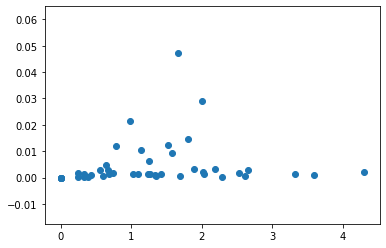

In [193]:
plot = [i[4] if i[4]<5 else 0 for i in win_list]
y = [i[1] if i[4]<5 else 0 for i in win_list]
plt.scatter(plot,y)

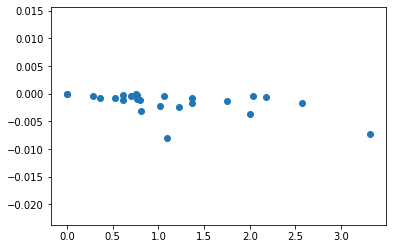

In [194]:
plot = [i[4] if i[4]<5 else 0 for i in lose_list]
y = [i[1] if i[4]<5 else 0 for i in lose_list]
plt.scatter(plot,y)